In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os,pickle
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [4]:
#loading tfidf weighted glove
X_train = pd.read_csv('train_data.csv')
X_test = pd.read_csv('test_data.csv')
y_train = pd.read_csv('train_y.csv')
y_test = pd.read_csv('test_y.csv')
X_train = X_train.drop(columns=['q1_glove','q2_glove'])
X_test = X_test.drop(columns=['q1_glove','q2_glove'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80000, 218)
(20000, 218)
(80000, 1)
(20000, 1)


In [5]:
X_train.head(3)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,33,26,55,57,10,11,8.0,21.0,0.380952,59,...,-2.139855,-2.311613,1.795510,0.620619,0.553700,3.809993,1.407675,2.855578,0.525131,-0.346143
1,2,1,32,51,6,10,5.0,16.0,0.312500,3,...,-0.062467,-1.863858,1.871059,-1.406960,1.277069,2.936751,1.117216,0.947758,-0.979430,0.498250
2,1,9,46,48,9,9,8.0,18.0,0.444444,10,...,1.164281,-0.332287,-1.011394,0.965205,-1.284390,2.202049,0.376836,0.152748,0.743389,1.018471


In [6]:
X_test.head(3)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,1,1,34,45,6,7,2.0,13.0,0.153846,2,...,0.460593,0.561536,1.241743,1.038899,0.640651,2.742492,-0.139486,-1.193969,-1.333971,0.870183
1,1,7,104,47,15,6,4.0,21.0,0.190476,8,...,-3.549720,-2.566788,-2.226354,-3.838565,5.421790,0.721425,3.389118,-0.105709,-1.030245,0.951145
2,8,9,41,61,8,12,3.0,20.0,0.150000,17,...,0.961544,-1.716296,-0.779302,1.910576,0.503394,2.622959,1.569724,0.009197,-0.500175,0.169689


In [7]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    #[TN FP]
    #[FN TP]   
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #precision = true positive / predicted positive
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #recall = true positive/ actual positive
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    # cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True,  fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


For values of alpha =  1e-05 The log loss is: 0.4084666467918253
For values of alpha =  0.0001 The log loss is: 0.4166652138288715
For values of alpha =  0.001 The log loss is: 0.4169049181783352
For values of alpha =  0.01 The log loss is: 0.39039296781937066
For values of alpha =  0.1 The log loss is: 0.4127663889259995
For values of alpha =  1 The log loss is: 0.45050625569340763
For values of alpha =  10 The log loss is: 0.5174243636228691


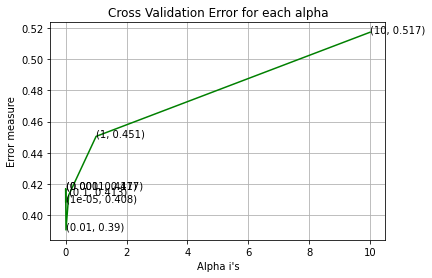

In [8]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.3871075272590785
For values of best alpha =  0.01 The test log loss is: 0.39039296781937066
Total number of data points : 20000


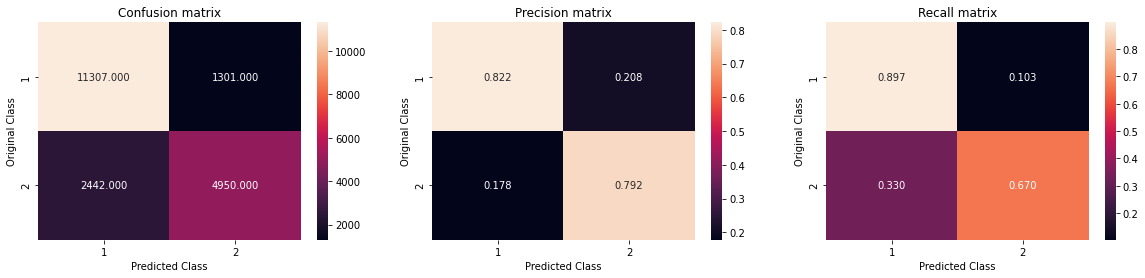

In [9]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.4129866311826877
For values of alpha =  0.0001 The log loss is: 0.41098432984499234
For values of alpha =  0.001 The log loss is: 0.41221884929505004
For values of alpha =  0.01 The log loss is: 0.39731329238936997
For values of alpha =  0.1 The log loss is: 0.41124292271561774
For values of alpha =  1 The log loss is: 0.4304464936483565
For values of alpha =  10 The log loss is: 0.4924470331394387


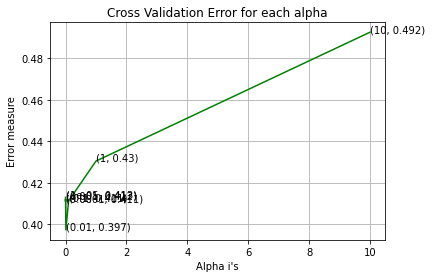

In [10]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.3950362674248996
For values of best alpha =  0.01 The test log loss is: 0.39731329238936997
Total number of data points : 20000


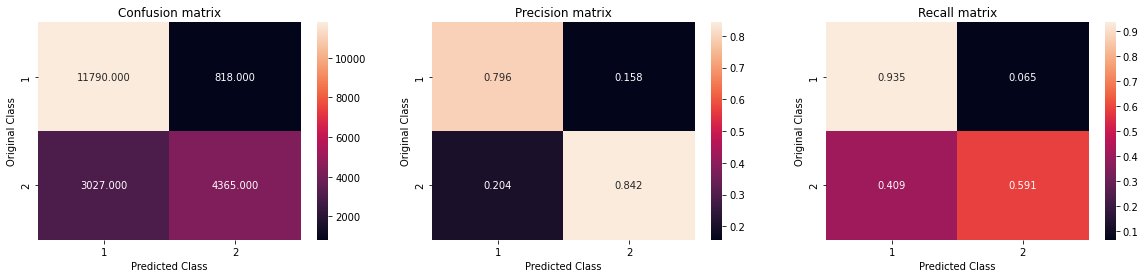

In [11]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

params = {'max_iter': [1000,1200,1500],
          'learning_rate': [0.1],
          'max_depth' : [25, 50, 75], 
          'l2_regularization': [1.5],
          'scoring': ['f1_micro'],
          }

hgboost_model = HistGradientBoostingClassifier()

#instantiate the gridsearch
hgb_grid = RandomizedSearchCV(hgboost_model, param_distributions = params,n_iter=30, scoring = 'neg_log_loss', n_jobs = -1,cv=3)
#fit on the grid 
hgb_grid.fit(X_train, y_train)

# Print the best parameters found
print(hgb_grid.best_params_)
# Print the best scores found
print()
print(hgb_grid.best_score_)

{'scoring': 'f1_micro', 'max_iter': 1500, 'max_depth': 50, 'learning_rate': 0.1, 'l2_regularization': 1.5}

-0.3113318559637615


Log loss for tfidf train data :  0.2844336021066648
Log loss for tfidf test data :  0.30611452608906764


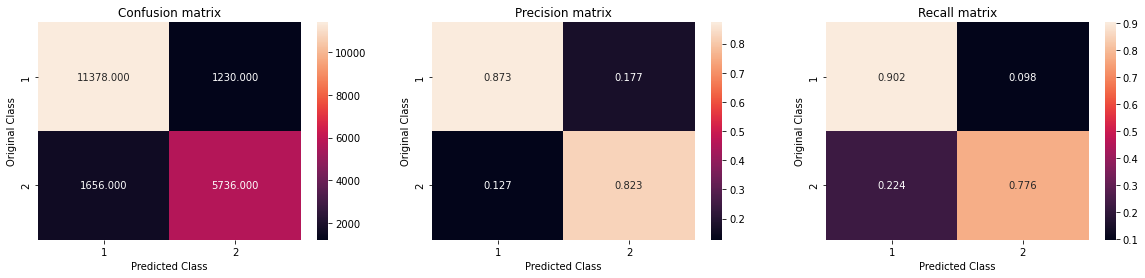

In [15]:
clf = HistGradientBoostingClassifier(scoring='f1_micro',max_iter=1500, max_depth=75, learning_rate=0.1, l2_regularization=1.5)
clf.fit(X_train, y_train)   

#log loss uses a exact prob score 
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

predict_y = cal_clf.predict_proba(X_train)

print("Log loss for tfidf train data : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = cal_clf.predict_proba(X_test)

print("Log loss for tfidf test data : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [16]:
from prettytable import PrettyTable
print("TF-IDF w2v")
x = PrettyTable()
x.field_names = ["ML Model", "Vectorizer", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression",'TF-IDF w2v', 0.385, 0.3942])
x.add_row(["Linear SVM", 'TF-IDF w2v', 0.387, 0.395])
x.add_row(["HistGradientBoost", 'TF-IDF w2v', 0.183,0.321])
print(x)

TF-IDF w2v
+---------------------+------------+----------------+---------------+
|       ML Model      | Vectorizer | Train log loss | Test log loss |
+---------------------+------------+----------------+---------------+
| Logistic Regression | TF-IDF w2v |     0.385      |     0.3942    |
|      Linear SVM     | TF-IDF w2v |     0.387      |     0.395     |
|  HistGradientBoost  | TF-IDF w2v |     0.183      |     0.321     |
+---------------------+------------+----------------+---------------+
